## Veri Seti Hakkında

Fashion-MNIST, Zalando'nun makale görsellerinden oluşan bir veri setidir ve 60.000 örnekten oluşan bir eğitim seti ve 10.000 örnekten oluşan bir test setinden oluşur. Her örnek, 10 sınıftan bir etiketle ilişkilendirilmiş 28x28 gri tonlamalı bir görüntüdür. Zalando, Fashion-MNIST'in makine öğrenimi algoritmalarının kıyaslamasında orijinal MNIST veri setinin doğrudan yerine geçmesini amaçlamaktadır. Aynı görüntü boyutunu ve eğitim ve test bölümlerinin yapısını paylaşır.

Orijinal MNIST veri seti çok sayıda el yazısı rakam içerir. Yapay Zeka/Makine Öğrenimi/Veri Bilimi topluluğu üyeleri bu veri setini çok seviyor ve algoritmalarını doğrulamak için bir kıyaslama aracı olarak kullanıyor. Aslında, MNIST genellikle araştırmacıların denediği ilk veri setidir. "MNIST'te işe yaramazsa, hiç işe yaramaz" dediler. "MNIST'te işe yarasa bile, başkalarında başarısız olabilir."

Zalando, orijinal MNIST veri setinin yerini almayı hedefliyor

### İçerik

Her görüntü 28 piksel yüksekliğinde ve 28 piksel genişliğinde olup toplam 784 pikseldir. Her pikselin, o pikselin açıklığını veya koyuluğunu gösteren tek bir piksel değeri vardır; daha yüksek sayılar daha koyu anlamına gelir. Bu piksel değeri, 0 ile 255 arasında bir tam sayıdır. Eğitim ve test veri setleri 785 sütundan oluşur. İlk sütun, sınıf etiketlerinden oluşur (yukarıya bakın) ve giyim eşyasını temsil eder. Diğer sütunlar, ilişkili görüntünün piksel değerlerini içerir.

Görüntüdeki bir pikseli bulmak için, x'i x = i * 28 + j olarak ayrıştırdığımızı varsayalım; burada i ve j, 0 ile 27 arasında tam sayılardır. Piksel, 28 x 28'lik bir matrisin i satırında ve j sütununda bulunur. Örneğin, pixel31, aşağıdaki ASCII diyagramında olduğu gibi soldan dördüncü sütunda ve üstten ikinci satırda bulunan pikseli gösterir.

### Etiketler

Her eğitim ve test örneği aşağıdaki etiketlerden birine atanmıştır:

0 Tişört/Üst
1 Pantolon
2 Kazak
3 Elbise
4 Mont
5 Sandalet
6 Gömlek
7 Spor Ayakkabı
8 Çanta
9 Bilekte Bot

### ÖZET

Her satır ayrı bir resimdir.
1. sütun sınıf etiketidir.
Kalan sütunlar piksel numaralarıdır (toplam 784).
Her değer, pikselin koyuluğunu gösterir (1 ila 255).

---
1. **Kurulum ve kütüphaneler**

* Neden? Reprodüksiyon için seed; eğitim loglarını sadeleştirmek için uyarı filtreleri.

In [1]:
import os, random, warnings, numpy as np, matplotlib.pyplot as plt
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# reproducibility (tam deterministik garanti değildir ama iyi bir başlangıç)
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

print("TF:", tf.__version__)

TF: 2.11.1


---
2. **Veriyi Yükle ve Ölçekle**

* Neden? Fashion-MNIST 28×28 gri imajlar. AE’lerde genellikle 0-1 aralığına normalize ederiz; çıktı katmanı sigmoid ile aynı aralığı hedefler.

In [3]:
# 60k train, 10k test; etiketlere ihtiyacımız yok (denetimsiz)
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

# [0,255] -> [0,1] ve kanalı ekle: (N,28,28,1)
x_train = (x_train.astype("float32") / 255.0)[..., None]
x_test  = (x_test.astype("float32")  / 255.0)[..., None]

print("Train:", x_train.shape, "Test:", x_test.shape)

4422102/4422102 [==============================] - 0s 0us/step
Train: (60000, 28, 28, 1) Test: (10000, 28, 28, 1)


---
3. **Gürültü ekle (Noisy → Clean eşlemesi)**

* Neden? DAE, girdi olarak gürültülü görüntüyü alır ve hedef olarak temiz görüntüyü tekrar üretmeyi öğrenir. Burada Gaussian gürültü kullanıyoruz (salt-and-pepper da ekleyebilirsin).

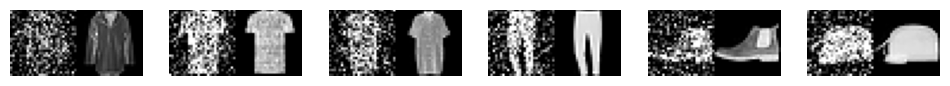

In [7]:
def add_gaussian_noise(x, sigma=0.4):
    noisy = x + sigma * tf.random.normal(tf.shape(x), dtype=x.dtype)
    return tf.clip_by_value(noisy, 0., 1.)

noise_sigma = 0.4
x_train_noisy = add_gaussian_noise(x_train, noise_sigma)
x_test_noisy  = add_gaussian_noise(x_test,  noise_sigma)

# Hızlı görsel kontrol
def show_triplet(clean, noisy, denoised=None, n=5):
    plt.figure(figsize=(12,3))
    for i in range(n):
        idx = np.random.randint(0, clean.shape[0])
        plt.subplot(1, n, i+1)
        if denoised is None:
            # üstte noisy, altta clean
            stack = np.concatenate([noisy[idx], clean[idx]], axis=1)
        else:
            # üst: noisy, alt: denoised
            stack = np.concatenate([noisy[idx], denoised[idx]], axis=1)
        plt.imshow(stack.squeeze(), cmap="gray")
        plt.axis("off")
    plt.show()

show_triplet(x_train, x_train_noisy, n=6)


---
4. **Model: Basit bir Conv Autoencoder**

Neden bu mimari?
* Encoder: Konvolüsyon + MaxPool ile özellik çıkarımı ve boyut azaltma.
* Bottleneck: Sıkıştırılmış temsil (latent kod).
* Decoder: ConvTranspose ile orijinal çözünürlüğe geri ölçekleme.
* Çıkışta sigmoid: 0-1 aralığına geri döndürmek için.

In [8]:
def build_dae():
    inp = layers.Input(shape=(28,28,1))
    # ENCODER
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inp)
    x = layers.MaxPool2D()(x)                           # 14x14x32
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    z = layers.MaxPool2D()(x)                           # 7x7x64  (bottleneck)

    # DECODER
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(z)  # 14x14x64
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)  # 28x28x32
    out = layers.Conv2D(1, 3, padding="same", activation="sigmoid")(x)                  # 28x28x1
    return models.Model(inp, out, name="fashion_dae")

dae = build_dae()
dae.summary()


Model: "fashion_dae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       

# 5) Kayıp fonksiyonu ve eğitim ayarları

**Neden MSE?**

* DAE’lerde **MSE** yaygın ve stabil. Alternatif: **MAE**, **SSIM kaybı** (algısal kalite), kombinasyonlar.
  **Callback’ler:** Erken durdurma ve en iyi modeli kaydetme.

In [9]:
dae.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")

ckpt = callbacks.ModelCheckpoint(
    "fashion_dae_best.keras", monitor="val_loss",
    save_best_only=True, verbose=1
)
early = callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
)

history = dae.fit(
    x_train_noisy, x_train,   # noisy -> clean
    validation_split=0.1,
    epochs=20,
    batch_size=128,
    callbacks=[ckpt, early],
    verbose=1
)

Epoch 1/20
422/422 [==============================] - ETA: 0s - loss: 0.0303  
Epoch 1: val_loss improved from inf to 0.01875, saving model to fashion_dae_best.keras
422/422 [==============================] - 57s 133ms/step - loss: 0.0303 - val_loss: 0.0187
Epoch 2/20
422/422 [==============================] - ETA: 0s - loss: 0.0169 
Epoch 2: val_loss improved from 0.01875 to 0.01586, saving model to fashion_dae_best.keras
422/422 [==============================] - 56s 133ms/step - loss: 0.0169 - val_loss: 0.0159
Epoch 3/20
422/422 [==============================] - ETA: 0s - loss: 0.0151  
Epoch 3: val_loss improved from 0.01586 to 0.01447, saving model to fashion_dae_best.keras
422/422 [==============================] - 57s 136ms/step - loss: 0.0151 - val_loss: 0.0145
Epoch 4/20
422/422 [==============================] - ETA: 0s - loss: 0.0141 
Epoch 4: val_loss improved from 0.01447 to 0.01377, saving model to fashion_dae_best.keras
422/422 [==============================] - 58s 137

---

# 6) Öğrenme eğrileri

**Neden?** Aşırı öğrenme (overfit) var mı, iyileşme durmuş mu görürüz.

---

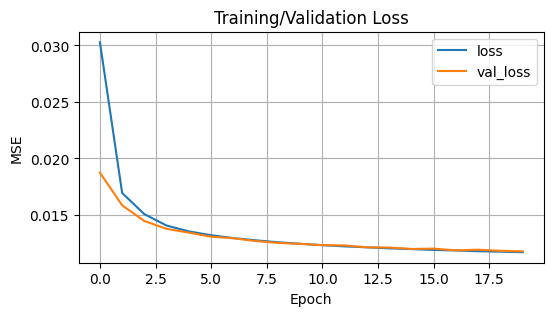

In [10]:
import pandas as pd
hist = pd.DataFrame(history.history)
ax = hist[["loss","val_loss"]].plot(figsize=(6,3), grid=True, title="Training/Validation Loss")
ax.set_xlabel("Epoch"); ax.set_ylabel("MSE");

# 7) Değerlendirme: MSE, PSNR, SSIM

**Neden?** MSE sayısal; **PSNR** (Peak Signal-to-Noise Ratio) ve **SSIM** (yapısal benzerlik) daha görsel algıyla uyumludur.

In [11]:
# En iyi ağırlıkları yükle (EarlyStopping zaten restore ediyor; emniyet için)
best = tf.keras.models.load_model("fashion_dae_best.keras")

denoised = best.predict(x_test_noisy, verbose=0)

# MSE
mse = float(tf.reduce_mean(tf.square(x_test - denoised)).numpy())

# PSNR (dB) - tf.image.psnr max_val=1.0 (0-1 aralığı varsaydık)
psnr = float(tf.reduce_mean(tf.image.psnr(x_test, denoised, max_val=1.0)).numpy())

# SSIM - ortalama SSIM
ssim = float(tf.reduce_mean(tf.image.ssim(x_test, denoised, max_val=1.0)).numpy())

print(f"MSE={mse:.5f} | PSNR={psnr:.2f} dB | SSIM={ssim:.4f}")

MSE=0.01185 | PSNR=19.66 dB | SSIM=0.6703


---

# 8) Çıktıları görselleştir

**Neden?** DAE’lerde **gözle kalite kontrol** çok önemli.

---

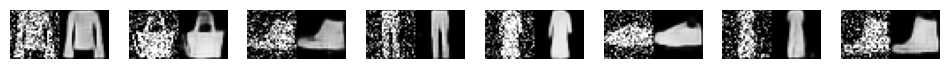

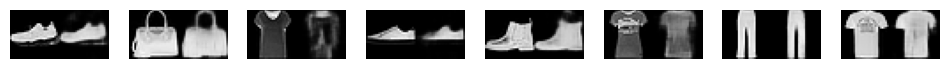

In [12]:
# 1) Noisy vs Denoised
show_triplet(x_test, x_test_noisy, denoised, n=8)

# 2) Orijinal vs Denoised (yan yana)
def compare(clean, den, n=6):
    plt.figure(figsize=(12,3))
    for i in range(n):
        idx = np.random.randint(0, clean.shape[0])
        pair = np.concatenate([clean[idx], den[idx]], axis=1)
        plt.subplot(1, n, i+1); plt.imshow(pair.squeeze(), cmap="gray"); plt.axis("off")
    plt.show()

compare(x_test, denoised, n=8)

---

## Mantık özeti (nedenleriyle)

* **Normalize (0–1)**: `sigmoid` çıkış ile uyumlu, stabil eğitim.
* **Gaussian gürültü**: DAE’yi “temiz temsil”e zorlar; model “denoising” öğrenir.
* **Conv AE**: Görüntüde lokal paternleri (kenar/doku) iyi temsil eder; **encoder** sıkıştırır, **decoder** geri kurar.
* **MSE kaybı**: Piksel bazlı fark; ilk adım için yeterli. (SSIM ile destekledik.)
* **EarlyStopping/Checkpoint**: Aşırı uyumu önleme ve en iyi modeli saklama.
* **PSNR/SSIM**: Algısal kaliteyi daha iyi yansıtan metrikler.

---

## Sık karşılaşılan sorular / iyileştirmeler

* **Gürültüyü ağır buldum** → `noise_sigma`yı 0.2–0.3 yap.
* **Daha iyi sonuç?**

  * Encoder/decoder katmanlarını artır (64→128 filtre, ek Conv blokları).
  * **Skip connections** (U-Net tarzı) ekle.
  * **MAE + SSIM** kombine loss dene (ör. `loss = 0.5*MAE + 0.5*(1-SSIM)` gibi, SSIM’i diferansiyellenebilir approx ile).
  * **Data augmentation** (küçük çeviri/döndürme) ile genelleme.
* **Hız yavaş** → Batch size ↑, mixed precision (`tf.keras.mixed_precision.set_global_policy('mixed_float16')`) ve GPU kullan.

---

Hazırsan bir üst seviye olarak **Skip-U-Net DAE**’yi de yazabiliriz ya da **salt-&-pepper** gürültüyü de ekleyip ikisini birlikte temizleyen bir model deneriz. İstersen “neleri değiştirirsem PSNR/SSIM artar?” diye bir mini deney planı da çıkarayım.


Harika sonuç! 🎉
Eğri ve metrikler, modelin gerçekten **gürültüyü temizlemeyi öğrendiğini** gösteriyor.

## Kısa yorum

* **Loss grafiği:** Eğitim ve doğrulama hatası birlikte ve istikrarlı biçimde düşüyor → aşırı öğrenme yok; \~15. epoch sonrası küçük iyileşmeler (plateau).
* **Test MSE = 0.01185**: Val ile uyumlu; iyi.
* **PSNR ≈ 19.7 dB**: σ=0.4 Gauss gürültü için makul (genelde 18–22 dB bandı).
* **SSIM ≈ 0.67**: Yapısal benzerlik orta-iyi; kenarlar/tekstür korunmuş, daha da iyileştirilebilir.
* Görsellerde “tuz-biber” benzeri ağır noktalar ciddi ölçüde kaybolmuş; **konturlar ve siluetler korunmuş**.

## Hızlı “iyileştirme” fikirleri (önce kolaylar)

1. **Skip connection (U-Net mini)**: İnce detayları geri getirmede çok yardımcı.
2. **Kayıp fonksiyonu:** `MAE + (1-SSIM)` kombinasyonu genelde MSE’den daha iyi algısal kalite verir.
3. **Strided Conv** (MaxPool yerine) + hafif **BatchNorm**: Stabilite ve keskinlik.
4. **LR düşürme:** `ReduceLROnPlateau` ile plateau’da LR azalt.
5. **Noise seviyesi**: Eğitimde σ=0.4 zor bir hedef; 0.3 ile de deneyip karşılaştırabilirsin (aynı test gürültüsüyle adil kıyas yap).

Aşağıya iki “plug-and-play” parça bırakıyorum: (A) U-Net mini mimarisi, (B) MAE+SSIM loss.

### A) U-Net mini (skip’li DAE)

```python
import tensorflow as tf
from tensorflow.keras import layers, models

def unet_dae():
    inp = layers.Input((28,28,1))
    # Encoder
    c1 = layers.Conv2D(32, 3, padding="same", activation="relu")(inp)
    p1 = layers.MaxPool2D()(c1)                      # 14x14
    c2 = layers.Conv2D(64, 3, padding="same", activation="relu")(p1)
    p2 = layers.MaxPool2D()(c2)                      # 7x7 (bottleneck)

    # Bottleneck
    b  = layers.Conv2D(128, 3, padding="same", activation="relu")(p2)

    # Decoder + skips
    u1 = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(b)  # 14x14
    m1 = layers.Concatenate()([u1, c2])
    u2 = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(m1) # 28x28
    m2 = layers.Concatenate()([u2, c1])

    out = layers.Conv2D(1, 3, padding="same", activation="sigmoid")(m2)
    return models.Model(inp, out, name="fashion_unet_dae")

model = unet_dae()
model.summary()
```

### B) MAE + (1-SSIM) birleşik kayıp

```python
import tensorflow as tf

def mae_ssim_loss(y_true, y_pred, alpha=0.5):
    # alpha: MAE ağırlığı (0..1); (1-alpha): SSIM ağırlığı
    mae  = tf.reduce_mean(tf.abs(y_true - y_pred))
    ssim = tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return alpha * mae + (1.0 - alpha) * (1.0 - ssim)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=lambda yt, yp: mae_ssim_loss(yt, yp, alpha=0.6))
```

> İpucu: U-Net + `MAE+SSIM` ile **SSIM’in** belirgin arttığını görürsün; PSNR da genelde yükselir.

### (Opsiyonel) LR azaltma

```python
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5, verbose=1)
early   = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)
ckpt    = ModelCheckpoint("fashion_dae_unet_best.keras", save_best_only=True, monitor="val_loss", verbose=1)

history = model.fit(x_train_noisy, x_train, validation_split=0.1,
                    epochs=30, batch_size=128, callbacks=[plateau, early, ckpt])
```

### Tek görseli denoising ve kaydetme

```python
import matplotlib.pyplot as plt
i = np.random.randint(0, x_test.shape[0])
noisy = x_test_noisy[i:i+1]
den   = model.predict(noisy, verbose=0)

fig, ax = plt.subplots(1,3, figsize=(7,3))
ax[0].imshow(x_test[i].squeeze(), cmap="gray");  ax[0].set_title("Clean");  ax[0].axis("off")
ax[1].imshow(noisy[0].squeeze(), cmap="gray");   ax[1].set_title("Noisy");  ax[1].axis("off")
ax[2].imshow(den[0].squeeze(), cmap="gray");     ax[2].set_title("Denoised"); ax[2].axis("off")
plt.tight_layout(); plt.show()
```

İstersen şimdi U-Net + MAE-SSIM ile bir koşu alalım; ardından **MSE/PSNR/SSIM**’i tekrar raporlayıp farkı birlikte okuyalım. Bu adım, AE’lerin **algısal kalite** tarafındaki farkını çok net gösterir.
